In [1]:
import sys 

import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from skimage import io

from data_generator import *
from unet import *
from res_unet import *
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
print(tf.__version__)

1.14.0


Using TensorFlow backend.


In [2]:
sys.path.append("../")
from dice_loss import *

In [3]:
TRAIN_PATH = 'data/train/'
XTRAIN_PATH = f'{TRAIN_PATH}/image'
YTRAIN_PATH = f'{TRAIN_PATH}/label'

TEST_PATH = 'data/test/'
XTEST_PATH = f'{TEST_PATH}/image'
YTEST_PATH = f'{TEST_PATH}/label'

MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [9]:
image_generator_train = ImageDataGenerator(
    rotation_range=0.2,
    rescale=1./255,
    shear_range=0,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator_train = ImageDataGenerator(
    rotation_range=0.2,
    shear_range=0,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

image_generator_test = ImageDataGenerator(
    rescale=1./255,
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

label_generator_test = ImageDataGenerator(
    # No rescale transform on target mask
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

In [10]:
train_generator = generator(
    TRAIN_PATH,
    image_generator_train,
    label_generator_train, 
    batch_sz=2
)
test_generator = generator(
    TEST_PATH,
    image_generator_test,
    label_generator_test
)

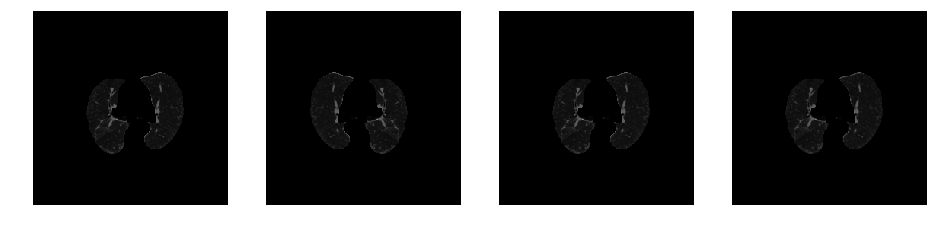

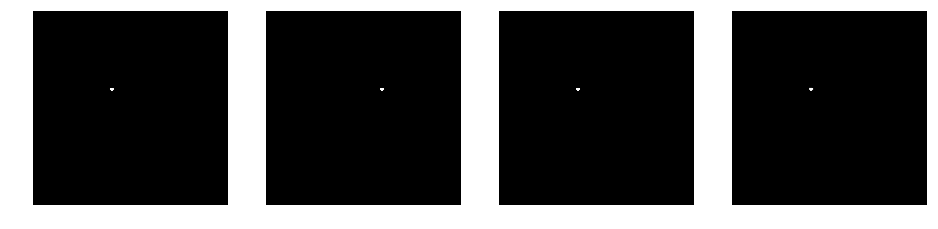

In [11]:
show_augmentation('data/train/image/2.tif', image_generator_train, n_rows=1)
show_augmentation('data/train/label/2.tif', label_generator_train, n_rows=1)

## Instantiate the U-Net

In [12]:
# model = unet()
model = res_unet()
model.compile(
    optimizer = Adam(lr = 1e-5),
    loss=dice_coef_weighted_loss,
    metrics = [
        'accuracy',
        dice_coef,
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives()
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=1, save_best_only=True)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 256, 256, 64) 256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 64) 128         input_2[0][0]                    
____________________________________________________________________________________________

## Train the U-Net

In [13]:
model.fit_generator(
    train_generator,
    steps_per_epoch = 1000,
    epochs = 20,
#     class_weight=class_weight
)

Found 475 images belonging to 1 classes.
Found 475 images belonging to 1 classes.
Epoch 1/20
1000/1000 [==============================] - 70s 70ms/step - loss: 0.9845 - acc: 0.9551 - dice_coef: 0.0025 - precision_1: 0.0146 - recall_1: 0.4749 - true_negatives_1: 124937856.0000 - true_positives_1: 84455.0000
Epoch 2/20
1000/1000 [==============================] - 63s 63ms/step - loss: 0.9711 - acc: 0.9985 - dice_coef: 0.0048 - precision_1: 0.7389 - recall_1: 0.3487 - true_negatives_1: 130611408.0000 - true_positives_1: 61598.0000
Epoch 3/20
1000/1000 [==============================] - 63s 63ms/step - loss: 0.9675 - acc: 0.9985 - dice_coef: 0.0054 - precision_1: 0.8216 - recall_1: 0.3906 - true_negatives_1: 130618488.0000 - true_positives_1: 68907.0000
Epoch 4/20
1000/1000 [==============================] - 63s 63ms/step - loss: 0.9646 - acc: 0.9986 - dice_coef: 0.0059 - precision_1: 0.8913 - recall_1: 0.4049 - true_negatives_1: 130623528.0000 - true_positives_1: 71883.0000
Epoch 5/20
100

## Test the U-Net

**Training set test**

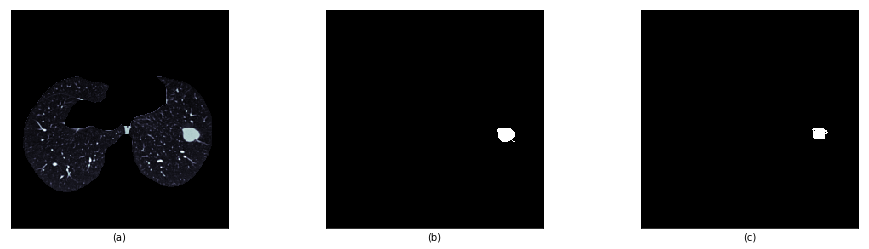

In [26]:
train_idx = np.random.randint(len(os.listdir('data/train/image')))
train_idx = 449
img0 = io.imread(f'data/train/image/{train_idx}.tif', as_gray=True)
mask0 = io.imread(f'data/train/label/{train_idx}.tif', as_gray=True)
x = img_to_array(img0)
y = img_to_array(mask0)

result = model.predict(x.reshape(1, 256, 256, 1))
# results = model.predict_generator(train_generator, 2, verbose=1)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(result.reshape(256, 256), vmin=0, vmax=1, cmap='bone')

axs[0].set_xlabel("(a)")
axs[1].set_xlabel("(b)")
axs[2].set_xlabel("(c)")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.show()

**Test set test**

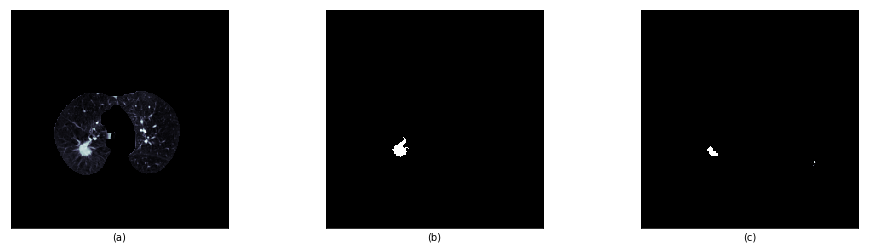

In [28]:
test_idx = np.random.randint(len(os.listdir('data/test/image')))
test_idx = 53
img0 = io.imread(f'data/test/image/{test_idx}.tif', as_gray=True)
mask0 = io.imread(f'data/test/label/{test_idx}.tif', as_gray=True)

x = img_to_array(img0)
y = img_to_array(mask0)

result = model.predict(x.reshape(1, 256, 256, 1))
# results = model.predict_generator(train_generator, 2, verbose=1)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(result.reshape(256, 256), vmin=0, vmax=1, cmap='bone')

axs[0].set_xlabel("(a)")
axs[1].set_xlabel("(b)")
axs[2].set_xlabel("(c)")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.show()